# *In situ* split calibration-validation

This script allows to separate the *in situ* polygons into a calibration set and a validation set. The user has to choose what percentage of pixels **per class** he wants to keep for calibration (``pc_cal``). The remaining pixels will be used to validate the classification.

Note that the script takes into account the fact that there cannot be calibration and validation pixels in the same polygon. If a pixel of a polygon is used for the calibration of the model, all the other pixels of this polygon are also used.

In [29]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from collections import defaultdict
from pathlib import Path

**Set directory**

In [30]:
computer_path = '/export/miro/ndeffense/LBRAT2104/'
grp_nb        = '99'

# Directory for all work files
work_path = f'{computer_path}STUDENTS/GROUP_{grp_nb}/TP/'

in_situ_prepro_path  = f'{work_path}B_IN_SITU_PREPRO/'
in_situ_cal_val_path = f'{work_path}C_IN_SITU_CAL_VAL/'

Path(in_situ_cal_val_path).mkdir(parents=True, exist_ok=True)

**Set parameters**

In [35]:
site = 'NAMUR'
year = '2020'

field_classif_code = 'grp_1_nb'
field_classif_name = 'grp_1'

pc_cal = 75
pc_val = 100-pc_cal


**Set filenames**

In [36]:
# Input file
in_situ_prepared_shp = f'{in_situ_prepro_path}{site}_{year}_IN_SITU_ROI_prepared.shp'

# Output files
in_situ_cal_shp = f'{in_situ_cal_val_path}{site}_{year}_IN_SITU_ROI_CAL_{pc_cal}pc.shp'
in_situ_val_shp = f'{in_situ_cal_val_path}{site}_{year}_IN_SITU_ROI_VAL_{pc_val}pc.shp'

print(in_situ_cal_shp)
print(in_situ_val_shp)

/export/miro/ndeffense/LBRAT2104/STUDENTS/GROUP_99/TP/C_IN_SITU_CAL_VAL/NAMUR_2020_IN_SITU_ROI_CAL_75pc.shp
/export/miro/ndeffense/LBRAT2104/STUDENTS/GROUP_99/TP/C_IN_SITU_CAL_VAL/NAMUR_2020_IN_SITU_ROI_VAL_25pc.shp


## 1. Open *in situ* data prepared

In [37]:
gdf = gpd.read_file(in_situ_prepared_shp)

display(gdf.head())

,id,lc_nb,lc,grp_nb,grp,class_nb,class,sub_nb,sub,grp_1_nb,grp_1,grp_A_nb,grp_A,area,pix_count,geometry
0,4,3,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3199,Grassland and meadows,3,Grassland and meadows,3,Grassland and meadows,1735,17,"MULTIPOLYGON (((630003.573 5594258.004, 630003..."
1,5,3,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3199,Grassland and meadows,3,Grassland and meadows,3,Grassland and meadows,14331,146,"POLYGON ((636962.589 5595674.757, 636966.536 5..."
2,6,3,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3199,Grassland and meadows,3,Grassland and meadows,3,Grassland and meadows,1768,18,"POLYGON ((635692.119 5593303.601, 635688.405 5..."
3,7,3,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3199,Grassland and meadows,3,Grassland and meadows,3,Grassland and meadows,7828,79,"POLYGON ((627911.368 5595749.375, 627942.033 5..."
4,9,3,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3199,Grassland and meadows,3,Grassland and meadows,3,Grassland and meadows,3197,39,"POLYGON ((633236.525 5596165.100, 633397.286 5..."


## 2. Add number of pixel of each class for each polygons

``crop_pixel`` : sum of all pixels belonging of all polygons of a given class

> All polygons from a same class will have the same pixel ratio !

In [39]:
gdf['crop_pix'] = gdf.groupby(field_classif_code)['pix_count'].transform('sum')

df = gdf[[field_classif_code,field_classif_name,'crop_pix']].drop_duplicates().sort_values('crop_pix', ascending=False)

df

,grp_1_nb,grp_1,crop_pix
221,1111,Winter wheat,29633
0,3,Grassland and meadows,23889
295,1121,Maize,8667
331,1811,Sugar beet,7400
352,1152,Barley six-row,6659
441,1511,Potatoes,6439
376,1192,Other cereals,6117
411,1771,Peas,3606
502,69,Forest,3109
401,1923,Flax hemp and other similar crops,2810


## 3. Split polygons in training and validation datasets


In [40]:
training_pixels = defaultdict(lambda: 0)
training_target = {}

cal_id_list = []
val_id_list = []

gdf_shuffle = gdf.sample(len(gdf), random_state=1)  # Shuffle geodataframe randomly

for i, row in gdf_shuffle.iterrows():

    id          = row['id']
    crop_code   = row[field_classif_code]
    crop_pix    = row['crop_pix']
    pix_count   = row['pix_count']

    crop_target = pc_cal/100 * crop_pix
    training_target[crop_code] = crop_target

    pixels = training_pixels[crop_code]

    if pixels + pix_count <= crop_target:  # If below crop target, add polygons in training set
        training_pixels[crop_code] = pixels + pix_count  # Update number of training pixels by crop code
        purpose = 0  # calibration
    else:                                  # If over crop target, add polygons in validation set
        purpose = 1  # validation because "crop target" is reached
    
    if purpose == 0:
        cal_id_list.append(id)
    else:
        val_id_list.append(id)


print(f'Number of polygons for training   : {len(cal_id_list)}')
print(f'Number of polygons for validation : {len(val_id_list)}')

cal_gdf = gdf[gdf['id'].isin(cal_id_list)]

val_gdf = gdf[gdf['id'].isin(val_id_list)]

Number of polygons for training   : 423
Number of polygons for validation : 114


**Get summary of the CAL/VAL splitting**

In [27]:
# Get number of pixels per class

pix_per_class_cal_df = cal_gdf.groupby([field_classif_code, field_classif_name])['pix_count'].agg('sum').to_frame().reset_index()
pix_per_class_cal_df = pix_per_class_cal_df.sort_values(by='pix_count', ascending=False)
pix_per_class_cal_df = pix_per_class_cal_df.rename(columns={"pix_count": "CAL_pix"})

pix_per_class_val_df = val_gdf.groupby([field_classif_code, field_classif_name])['pix_count'].agg('sum').to_frame().reset_index()
pix_per_class_val_df = pix_per_class_val_df.sort_values(by='pix_count', ascending=False)
pix_per_class_val_df = pix_per_class_val_df.rename(columns={"pix_count": "VAL_pix"})

# Get number of polygons per class

poly_per_class_cal_df = cal_gdf.groupby([field_classif_code, field_classif_name])[field_classif_code].agg('count').reset_index(name='poly_count')
poly_per_class_cal_df = poly_per_class_cal_df.sort_values(by='poly_count', ascending=False)
poly_per_class_cal_df = poly_per_class_cal_df.rename(columns={"poly_count": "CAL_poly"})

poly_per_class_val_df = val_gdf.groupby([field_classif_code, field_classif_name])[field_classif_code].agg('count').reset_index(name='poly_count')
poly_per_class_val_df = poly_per_class_val_df.sort_values(by='poly_count', ascending=False)
poly_per_class_val_df = poly_per_class_val_df.rename(columns={"poly_count": "VAL_poly"})


# Merge 2 previous dataframe in a single one
#pix_poly_per_class_df = pix_per_class_cal_df.merge(poly_per_class_df, on=[field_classif_code, field_classif_name], how="outer")


# Merge 4 previous dataframe in a single one
summary_df = pix_per_class_cal_df.merge(pix_per_class_val_df,on=[field_classif_code, field_classif_name]).merge(poly_per_class_cal_df,on=[field_classif_code, field_classif_name]).merge(poly_per_class_val_df,on=[field_classif_code, field_classif_name])

display(summary_df)

,grp_1_nb,grp_1,CAL_pix,VAL_pix,CAL_poly,VAL_poly
0,1111,Winter wheat,22187,7446,56,18
1,3,Grassland and meadows,17914,5975,176,45
2,1121,Maize,6477,2190,26,10
3,1811,Sugar beet,5416,1984,15,6
4,1152,Barley six-row,4958,1701,17,3
5,1511,Potatoes,4826,1613,12,2
6,1192,Other cereals,4434,1683,12,5
7,1771,Peas,2454,1152,8,2
8,69,Forest,2314,795,31,4
9,1923,Flax hemp and other similar crops,2074,736,7,1


**Plot calibration and validation *in situ* data**

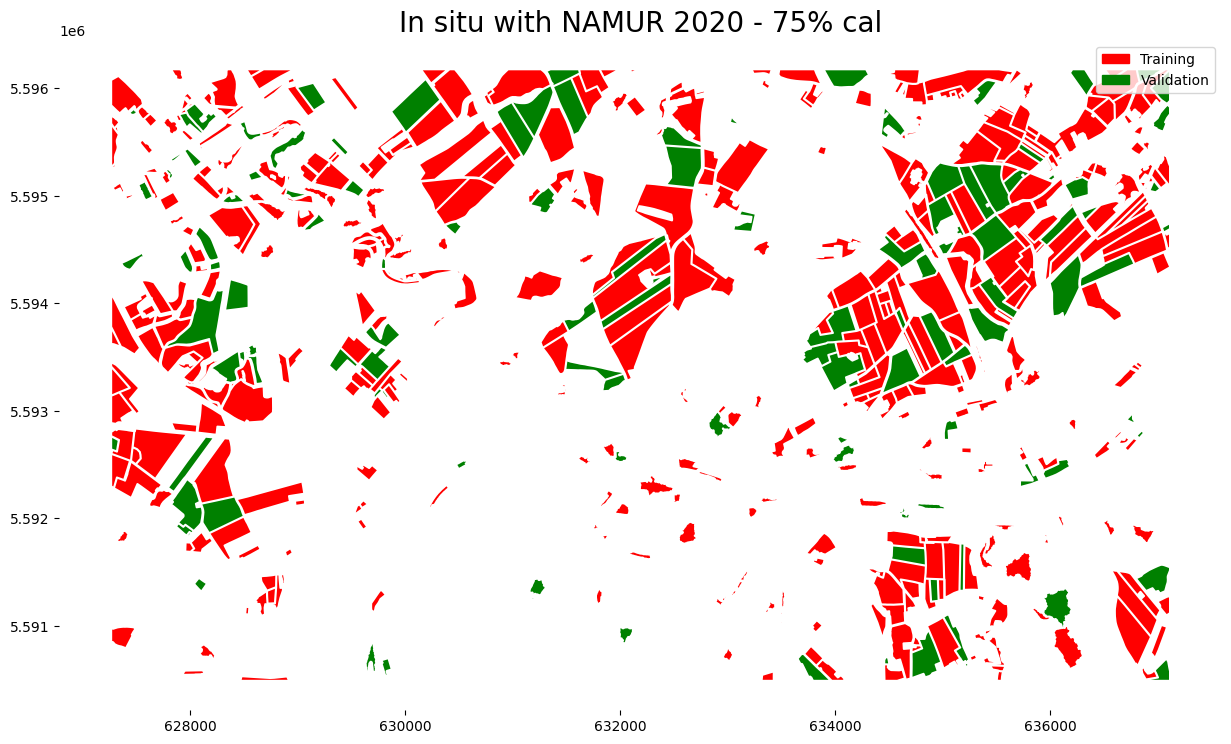

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))

cal_gdf.plot(ax=ax,
            color='red')

val_gdf.plot(ax=ax,
            color='green')

ax.set_title(f'In situ with {site} {year} - {pc_cal}% cal',fontsize=20)

cal_patch = mpatches.Patch(color='red', label='Training')
val_patch = mpatches.Patch(color='green', label='Validation')


plt.legend(handles=[cal_patch, val_patch])

plt.box(False)

**Write geodataframe into a shapefile**

In [43]:
cal_gdf.to_file(in_situ_cal_shp)
val_gdf.to_file(in_situ_val_shp)

print(f'Two shapefiles have been created :\n {in_situ_cal_shp} \n {in_situ_val_shp}')

Two shapefiles have been created :
 /export/miro/ndeffense/LBRAT2104/STUDENTS/GROUP_99/TP/C_IN_SITU_CAL_VAL/NAMUR_2020_IN_SITU_ROI_CAL_75pc.shp 
 /export/miro/ndeffense/LBRAT2104/STUDENTS/GROUP_99/TP/C_IN_SITU_CAL_VAL/NAMUR_2020_IN_SITU_ROI_VAL_25pc.shp
